In [1]:
import pandas as pd

In [2]:
%run data_cleaning.ipynb
%run data_exploration.ipynb

Total number of rows:  11619
Total number of columns:  19


# (Data cleaning)

- Create a column for the booking date and convert to datetime (day_scrap, hour_scrap)

In [3]:
cur_time = datetime.datetime.now()
year = cur_time.strftime('%Y')

In [4]:
dataset['date']=pd.to_datetime(dataset['day_scrap'].astype(str) + ' ' + 'May' + ' ' + year + ' '+ dataset['hour_scrap'].astype(str), format='%d %b %Y %H')

# DATA VISUALIZATION

* [Setting-up](#setting_up)
* [Bar Chart](#bar_chart)
* [Boxplot](#box_plot)
* [Lineplot](#line_plot)
* [Scatter plot](#scatter_plot)
* [Heatmap](#heatmap)

## Setting-up <a id="setting_up"></a>

In [5]:
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns 
import datetime
import warnings

%matplotlib inline
warnings.filterwarnings("ignore")

There are some outliers in the data set for ticket_price. Those are removed for data visualization, as it may significantly influence statistics.

In [6]:
# dataset=dataset.loc[(dataset.ticket_price<6000)].reset_index(drop=True)

- Calculate total duration of round trip

In [7]:
dataset['tot_duration'] = (dataset["out_duration"] + dataset["in_duration"]).reset_index(drop=True)

In [8]:
nyc=dataset.loc[dataset.arr_city=='JFK'].reset_index(drop=True)
sao=dataset.loc[dataset.arr_city=='GRU'].reset_index(drop=True)

## Bar chart <a id="bar_chart"></a>

#### a. Count of flights by destination and airline company

To begin with, a general overview of the data set is provided below. It represents the number and frequency of flights based on the destination and airline company.

In [9]:
barplot = dataset.groupby(["arr_city", "out_airline_company"]).size().reset_index(name="N")
barplot["group_count"] = barplot.groupby("arr_city")["N"].transform("sum")
barplot['percent']=barplot['N']/barplot["group_count"]
barplot

,arr_city,out_airline_company,N,group_count,percent
0,GRU,Lufthansa,3051,5680,0.537148
1,GRU,Swiss,2629,5680,0.462852
2,JFK,Lufthansa,2891,5939,0.486782
3,JFK,Swiss,3048,5939,0.513218


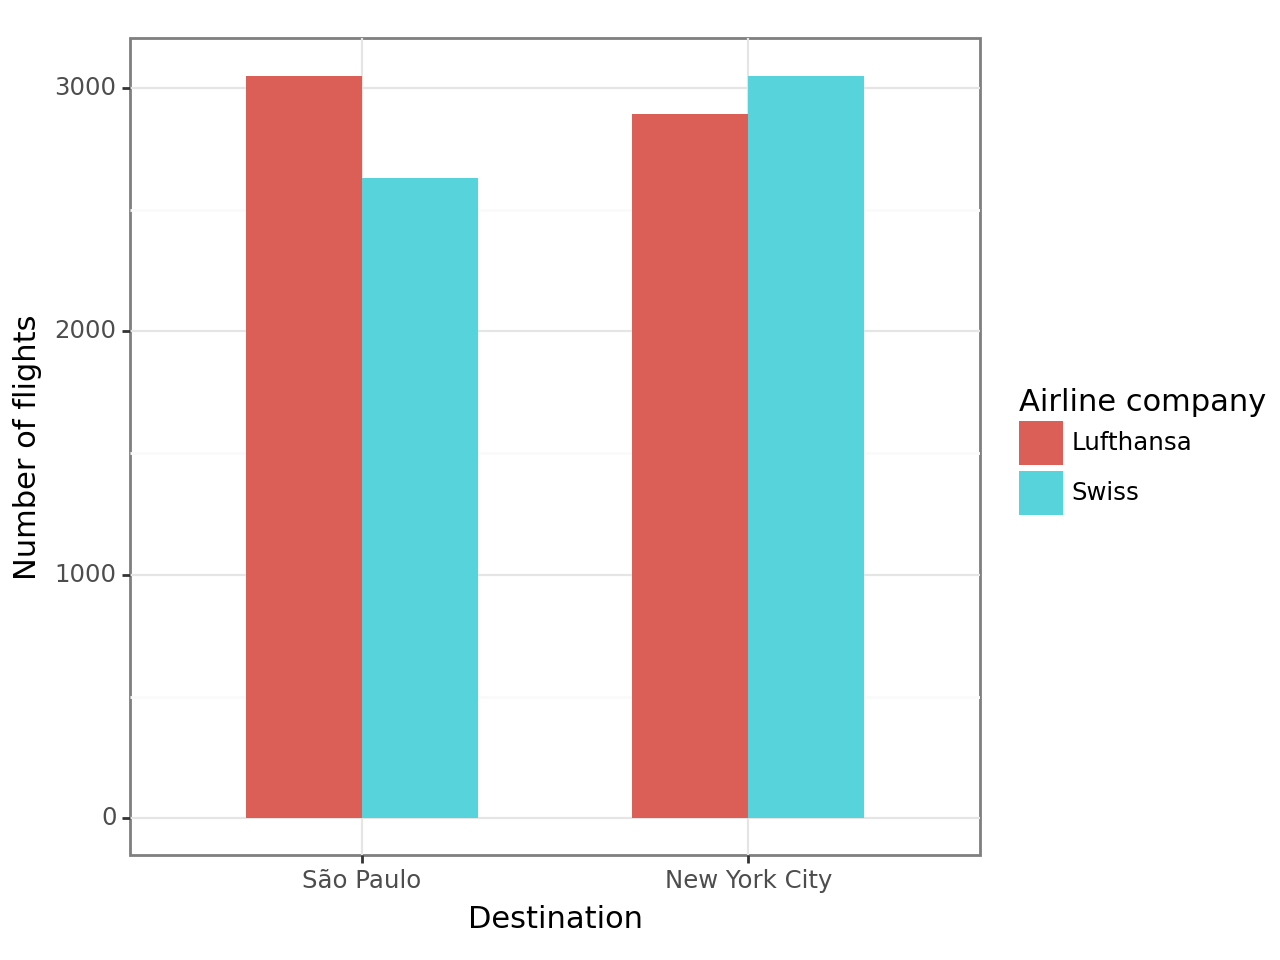

<Figure Size: (640 x 480)>

In [10]:
f1= (ggplot(barplot, aes(x="arr_city", y="N", fill="out_airline_company"))
+ geom_bar(stat="identity", position="dodge", width=0.6, size=0.5)
+ labs(x="Destination", y="Number of flights", fill="Airline company")
+ scale_x_discrete(labels=["São Paulo", "New York City"])
+ theme_bw()
)
f1

This bar chart is accompanied by a legend that distinguishes both airline companies, facilitating a straightforward comparison between them. In fact, it can be observed that Lufthansa operates more flights to São Paulo, while Swiss Airline has a higher number of flights to New York City. However, the difference is not huge and, for both destinations, the count of flights is also almost the same.

#### b. Minimum ticket prices based on the day of the week

Additional bar charts display the minimum ticket prices for different days of the week, comparing the prices and variation for the two airline companies.

In [11]:
def bar_chart(dataset):
    barplot=dataset.filter(['date','ticket_price','out_airline_company'])
    barplot['day_of_week'] = dataset['date'].dt.strftime('%A')
    
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    barplot['day_of_week'] = pd.Categorical(barplot['day_of_week'], categories=weekday_order, ordered=True)
    
    min_prices = barplot.groupby(['day_of_week','out_airline_company'])['ticket_price'].min().reset_index()
    
    f2=(ggplot(min_prices, aes(x='day_of_week', y="ticket_price", fill='out_airline_company'))
    + geom_bar(stat="identity", position="stack", width=0.8, size=0.9)
    + labs(x="Day of the week", y="Ticket price", fill="Airline")
    + scale_fill_discrete(labels=["Lufthansa", "Swiss"])
    + theme_bw()
    )
    print(f2)
    

From Brussels to New York City

- For NYC, it seems buying flight tickets on Monday, Tuesday, Saturday or Sunday would be more beneficial. In addition, prices of flights operated by Lufthansa are more stable than Swiss Airline.

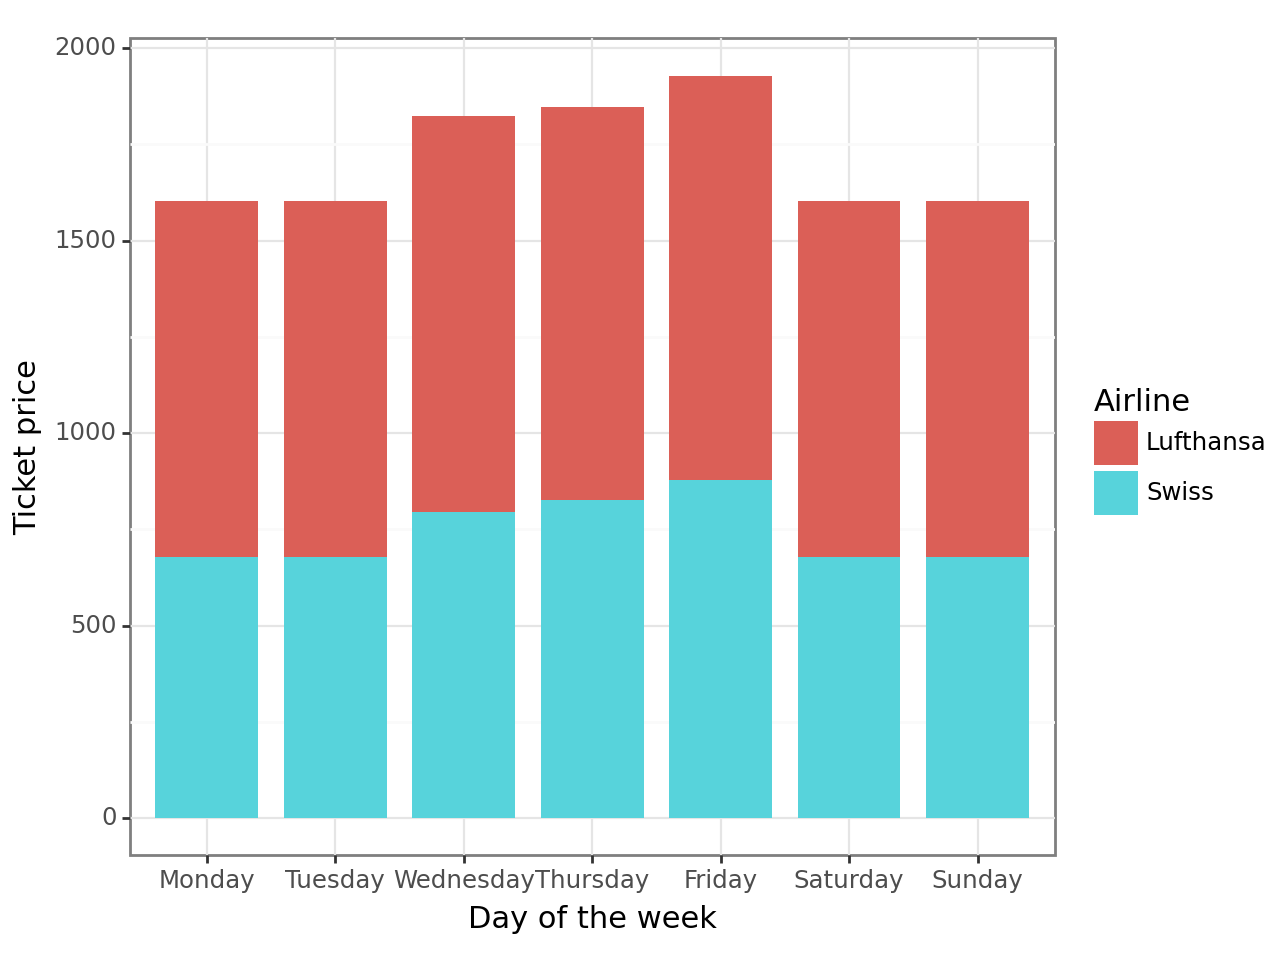

In [12]:
bar_chart(nyc)

From Brussels to Sao Paulo
- For Sao Paulo, Swiss Airline has significantly deacreased its prices on Tuesday compared to other days of the week.

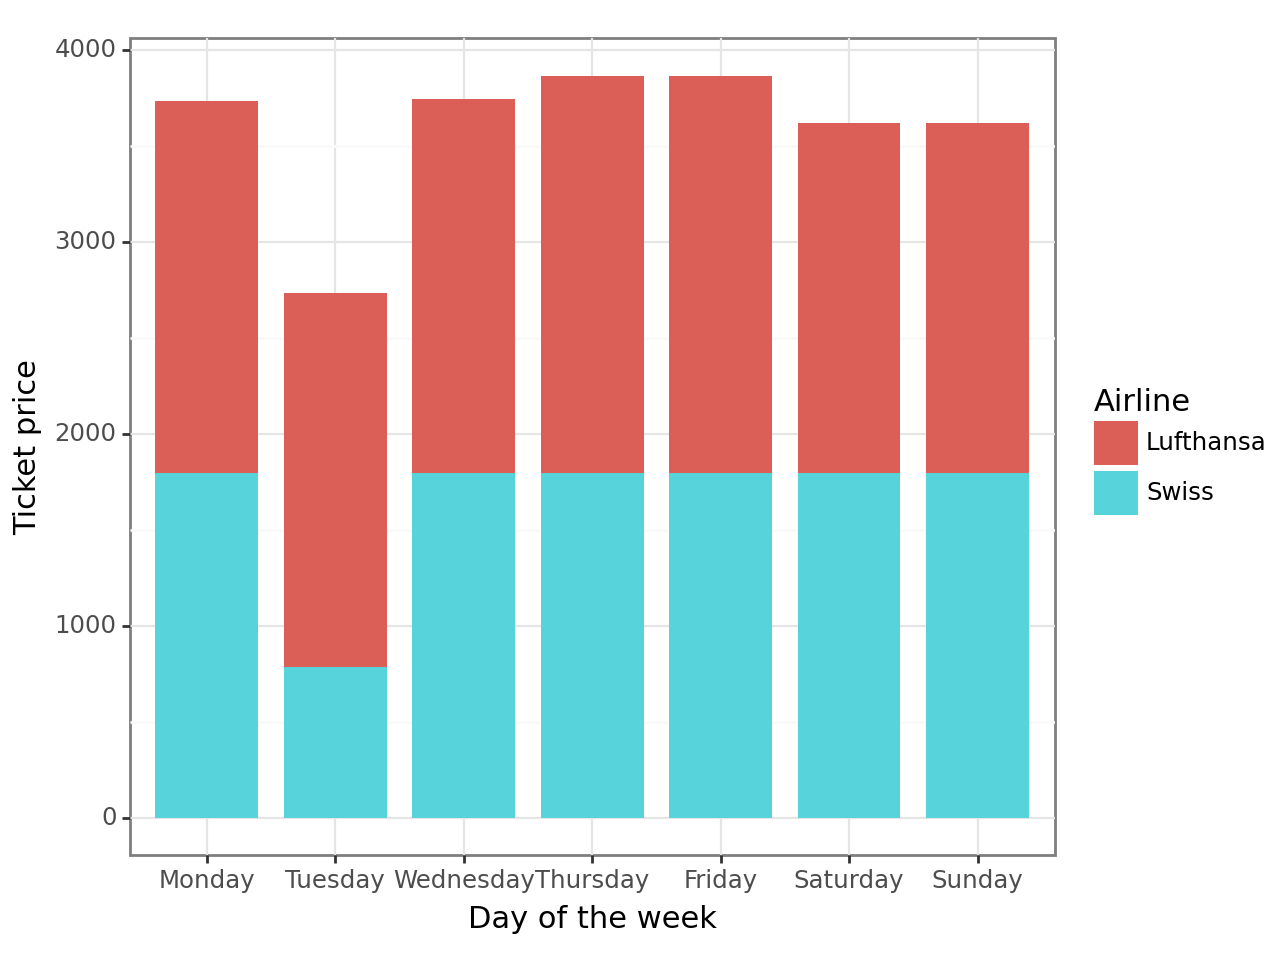

In [13]:
bar_chart(sao)

Each bar in the chart represents the minimum price at which the flight ticket can be bought for a specific day and airline company. The bars are stacked, allowing for easy visual comparison of the prices between the two companies on each day. The visual charts indicate that prices do vary depending on the day of the week. Especially, Swiss Airline's prices tend to decrease or increase more than Lufthansa's.

## Boxplot <a id="box_plot"></a>

These boxplots provide insights into the distribution of prices, specifically its central tendency, spread, and presence of outliers.

In [40]:
def boxplot(dataset):
    f3 = (
    ggplot(dataset, aes(y='ticket_price', x='out_airline_company'))
    + geom_boxplot(color="blue", size=0.5, width=0.1, alpha=0.5)
    + labs(x="Cities", y="Prices")
    + theme_bw()
    )
    f3
    f3 = f3 + stat_boxplot(geom = "errorbar", width = 0.05,  size = 0.5, color = 'blue')
    f3

    print(f3 + stat_summary(fun_data="mean_se", geom="point", size=4, color="red", fill="red"))


From Brussels to New York City

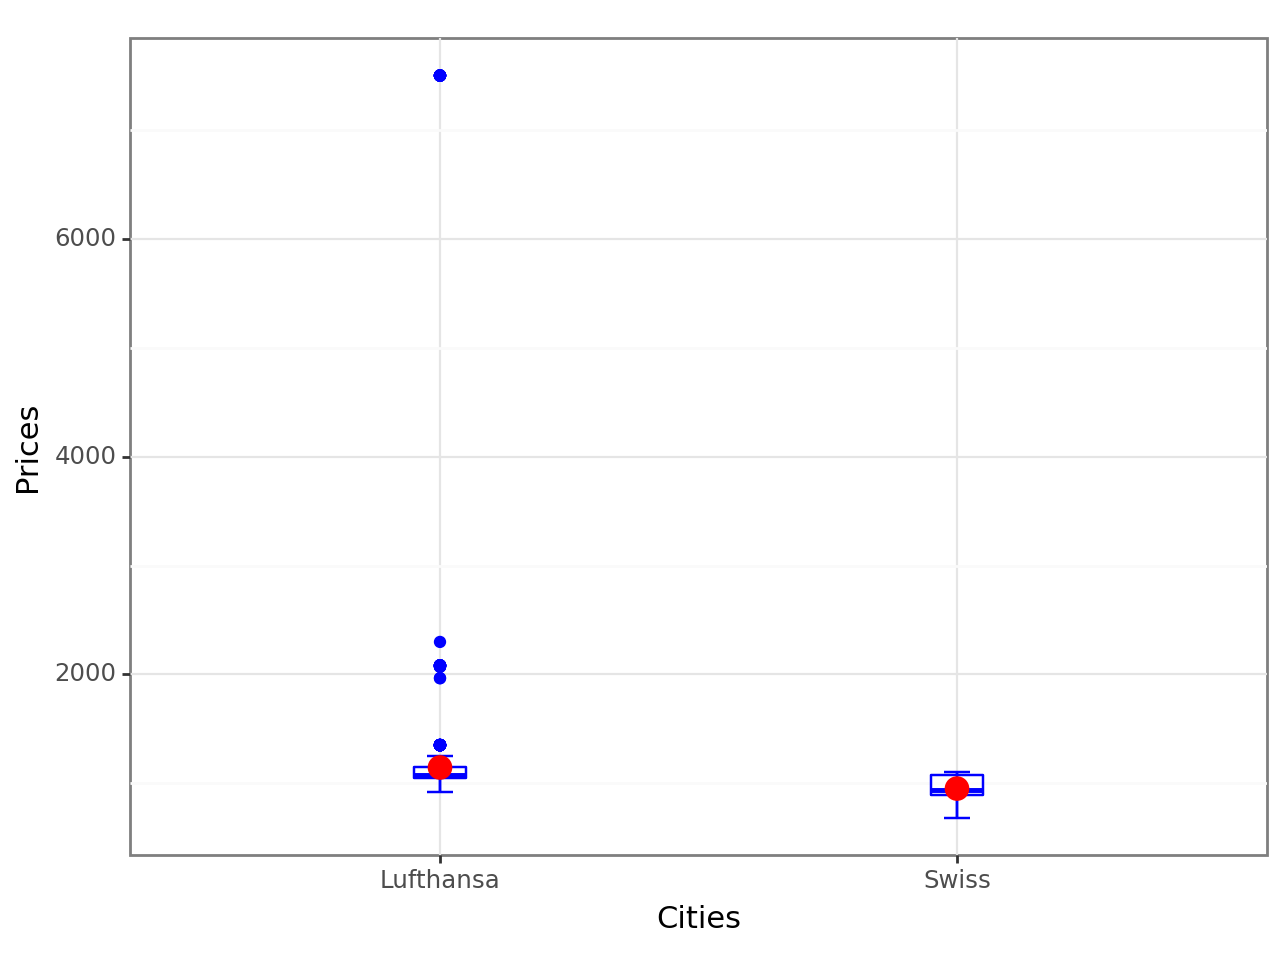

In [41]:
boxplot(nyc)

From Brussels to Sao Paulo

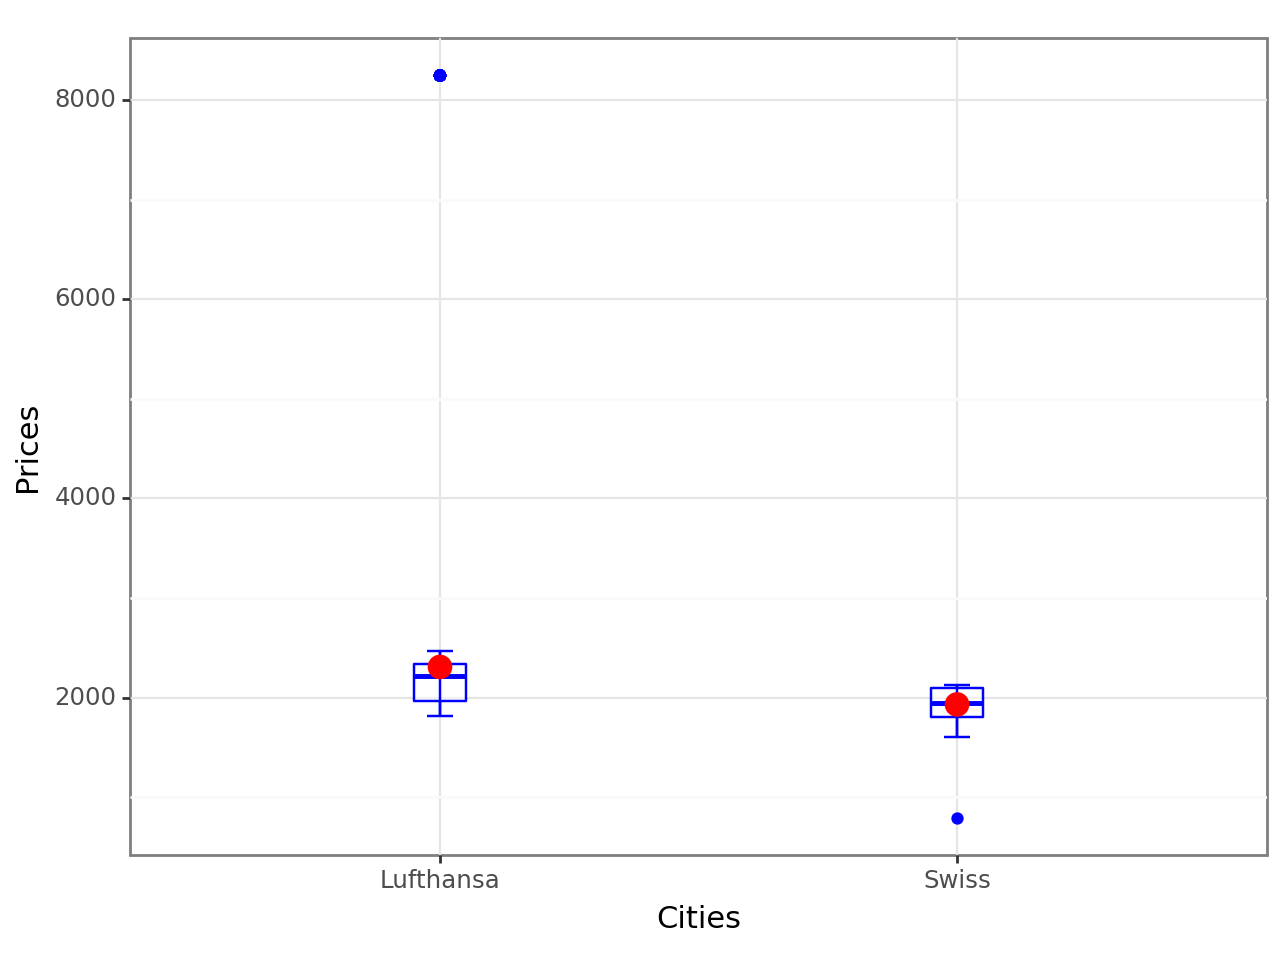

In [42]:
boxplot(sao)

For both destinations, it can be observed that Swiss Airline offers its flight tickets at lower prices than Lufthansa, but the difference does not seem to be significant. Moreover, Lufthansa tends to have more unexpected outliers with some ticket prices going over 7000 Euros.

## Lineplot <a id="line_plot"></a>

One of the primary goals of this project is to assist travelers in identifying the optimal time to book flights. To achieve this, line plots are employed to visualize the variations in flight prices over time.

### a. Based on booking day

In [48]:
def lineplot_day(dataset):
    # booking day
    lineplot=dataset.filter(['date', 'arr_city','out_airline_company','ticket_price'])
    lineplot['day_booking']=lineplot['date'].dt.strftime('%d %b')

    # min price per day
    day_price=lineplot.groupby(['day_booking','out_airline_company'])['ticket_price'].agg(['min','mean','max'])
    day_price=day_price.reset_index()
    
    # transform to list
    date = day_price[day_price.out_airline_company=='Lufthansa']['day_booking'].tolist()
    price_lufthansa= day_price[day_price.out_airline_company == 'Lufthansa']['mean'].tolist()
    price_swiss= day_price[day_price.out_airline_company == 'Swiss']['mean'].tolist()
   
    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, "-s", color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')
    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss,"-s",color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

- From Brussels to New York City

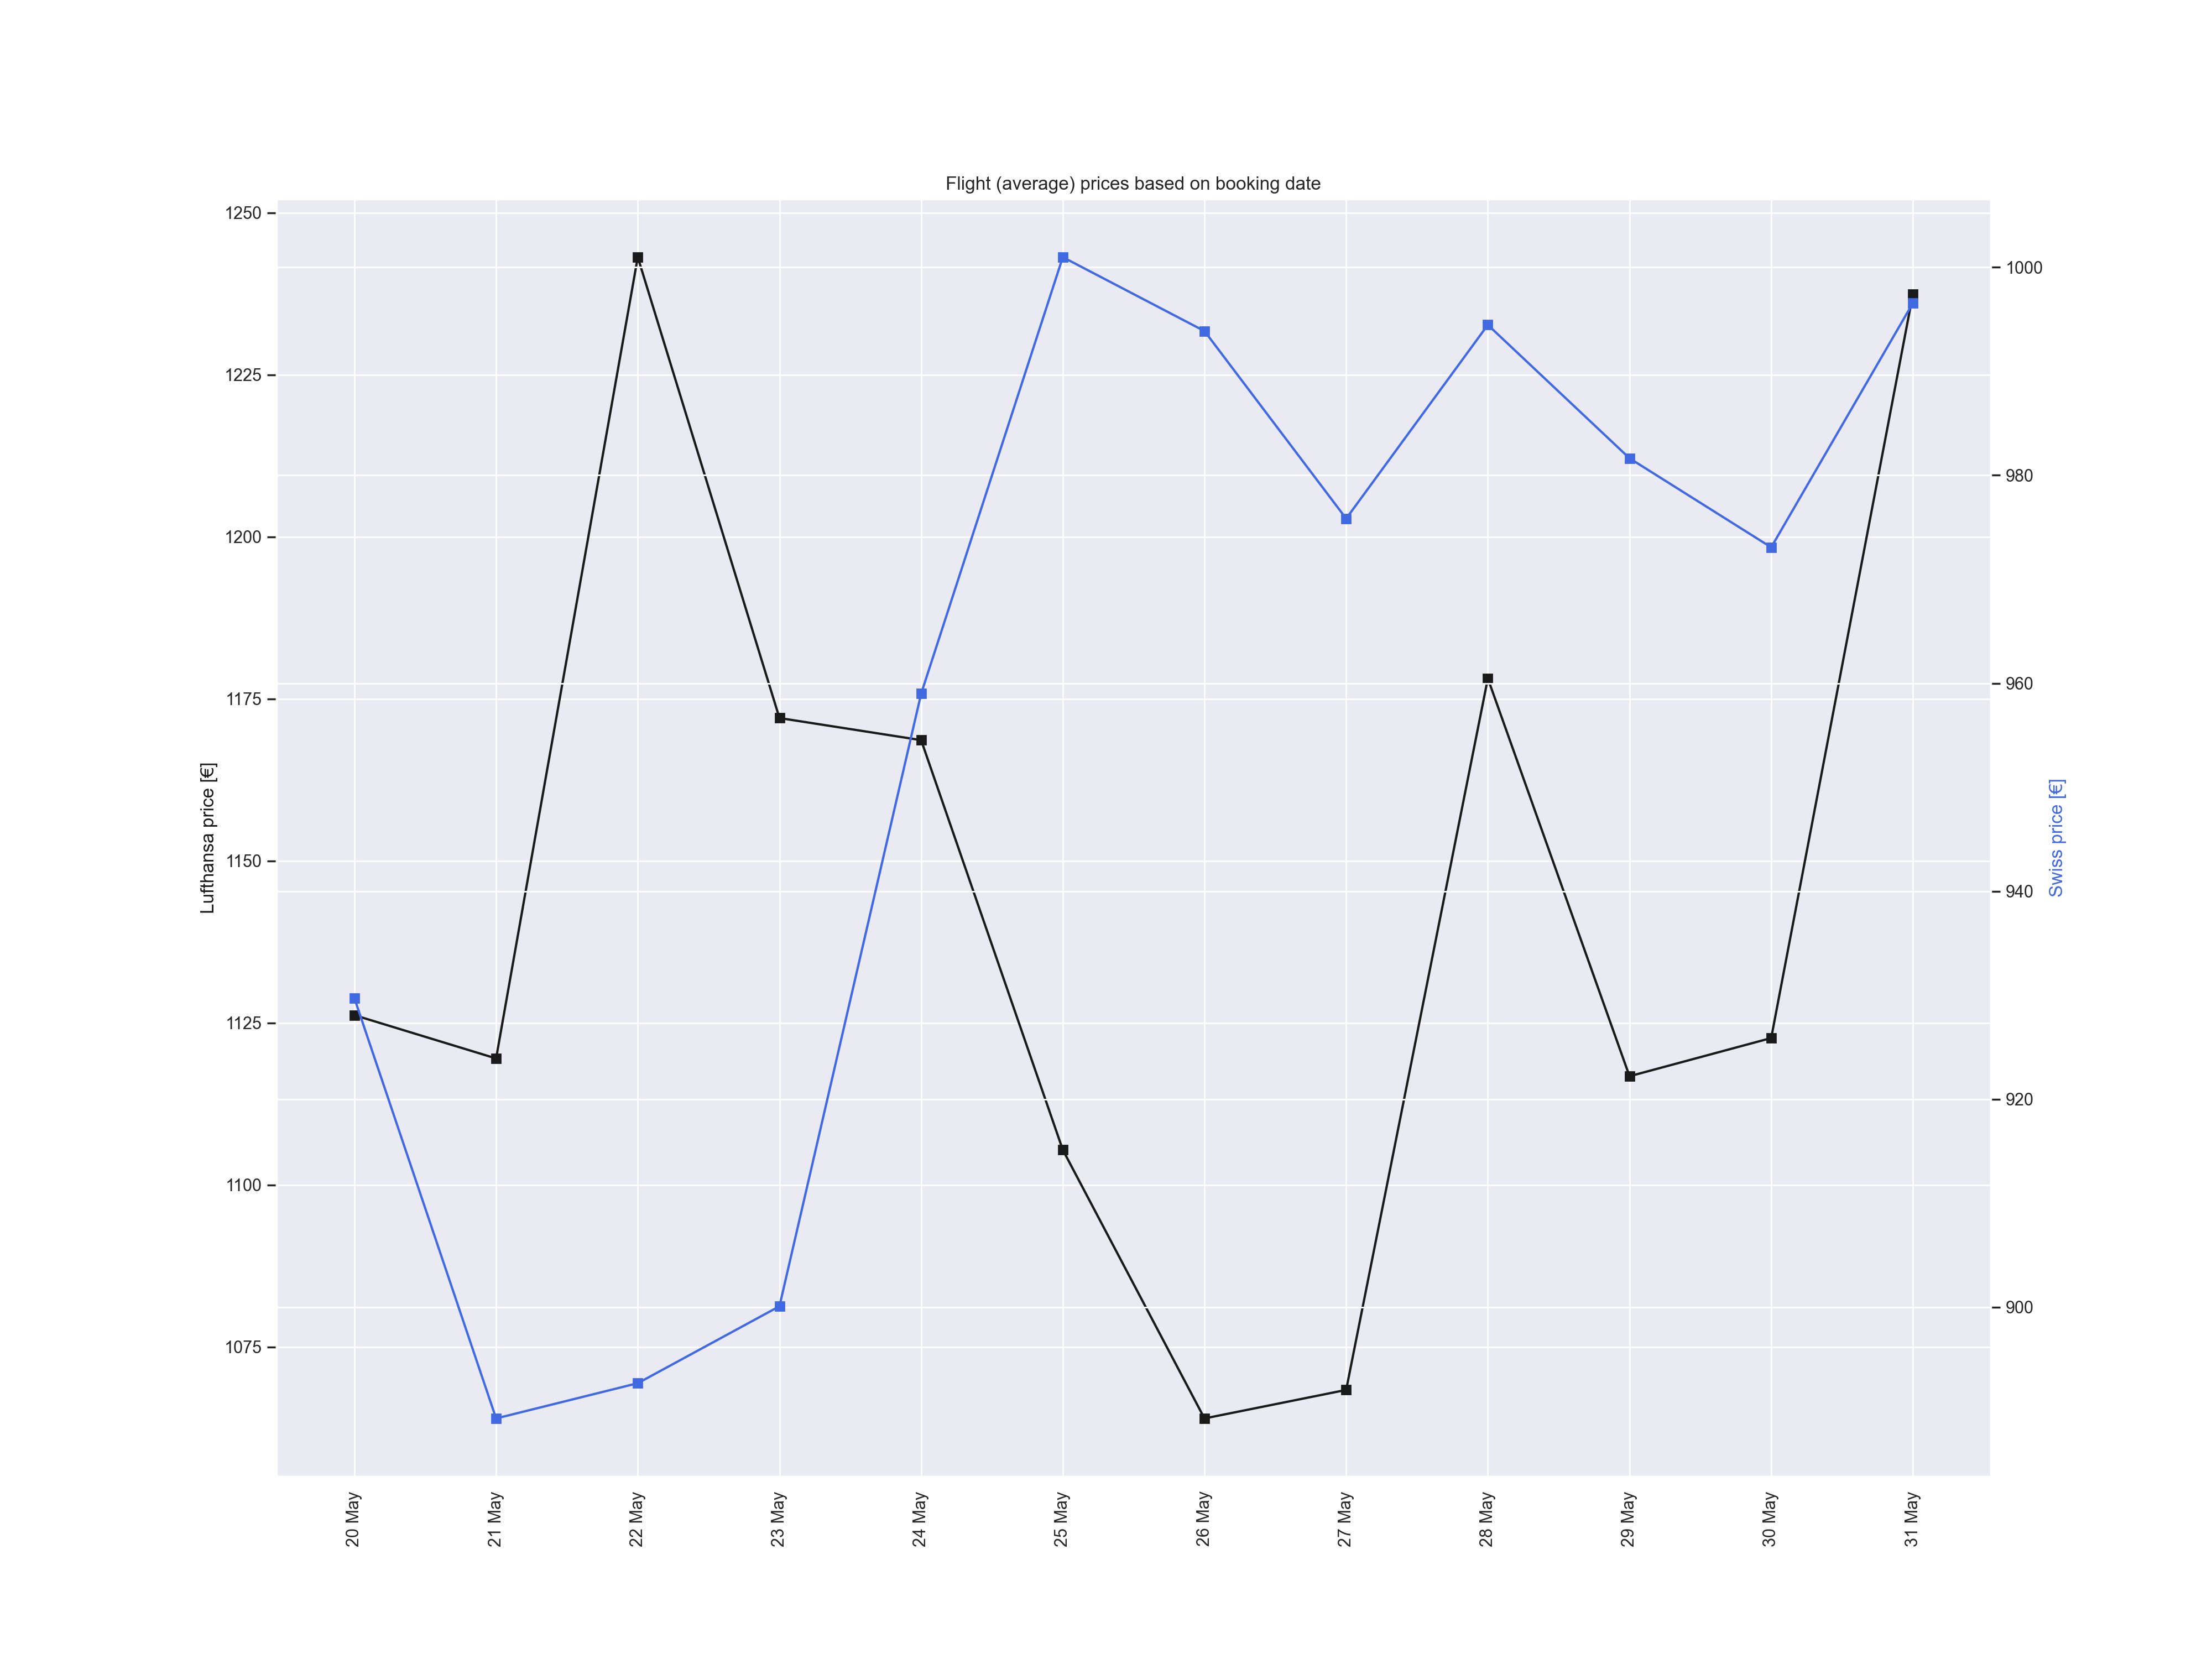

In [49]:
lineplot_day(dataset=nyc)

- From Brussels to Sao Paulo

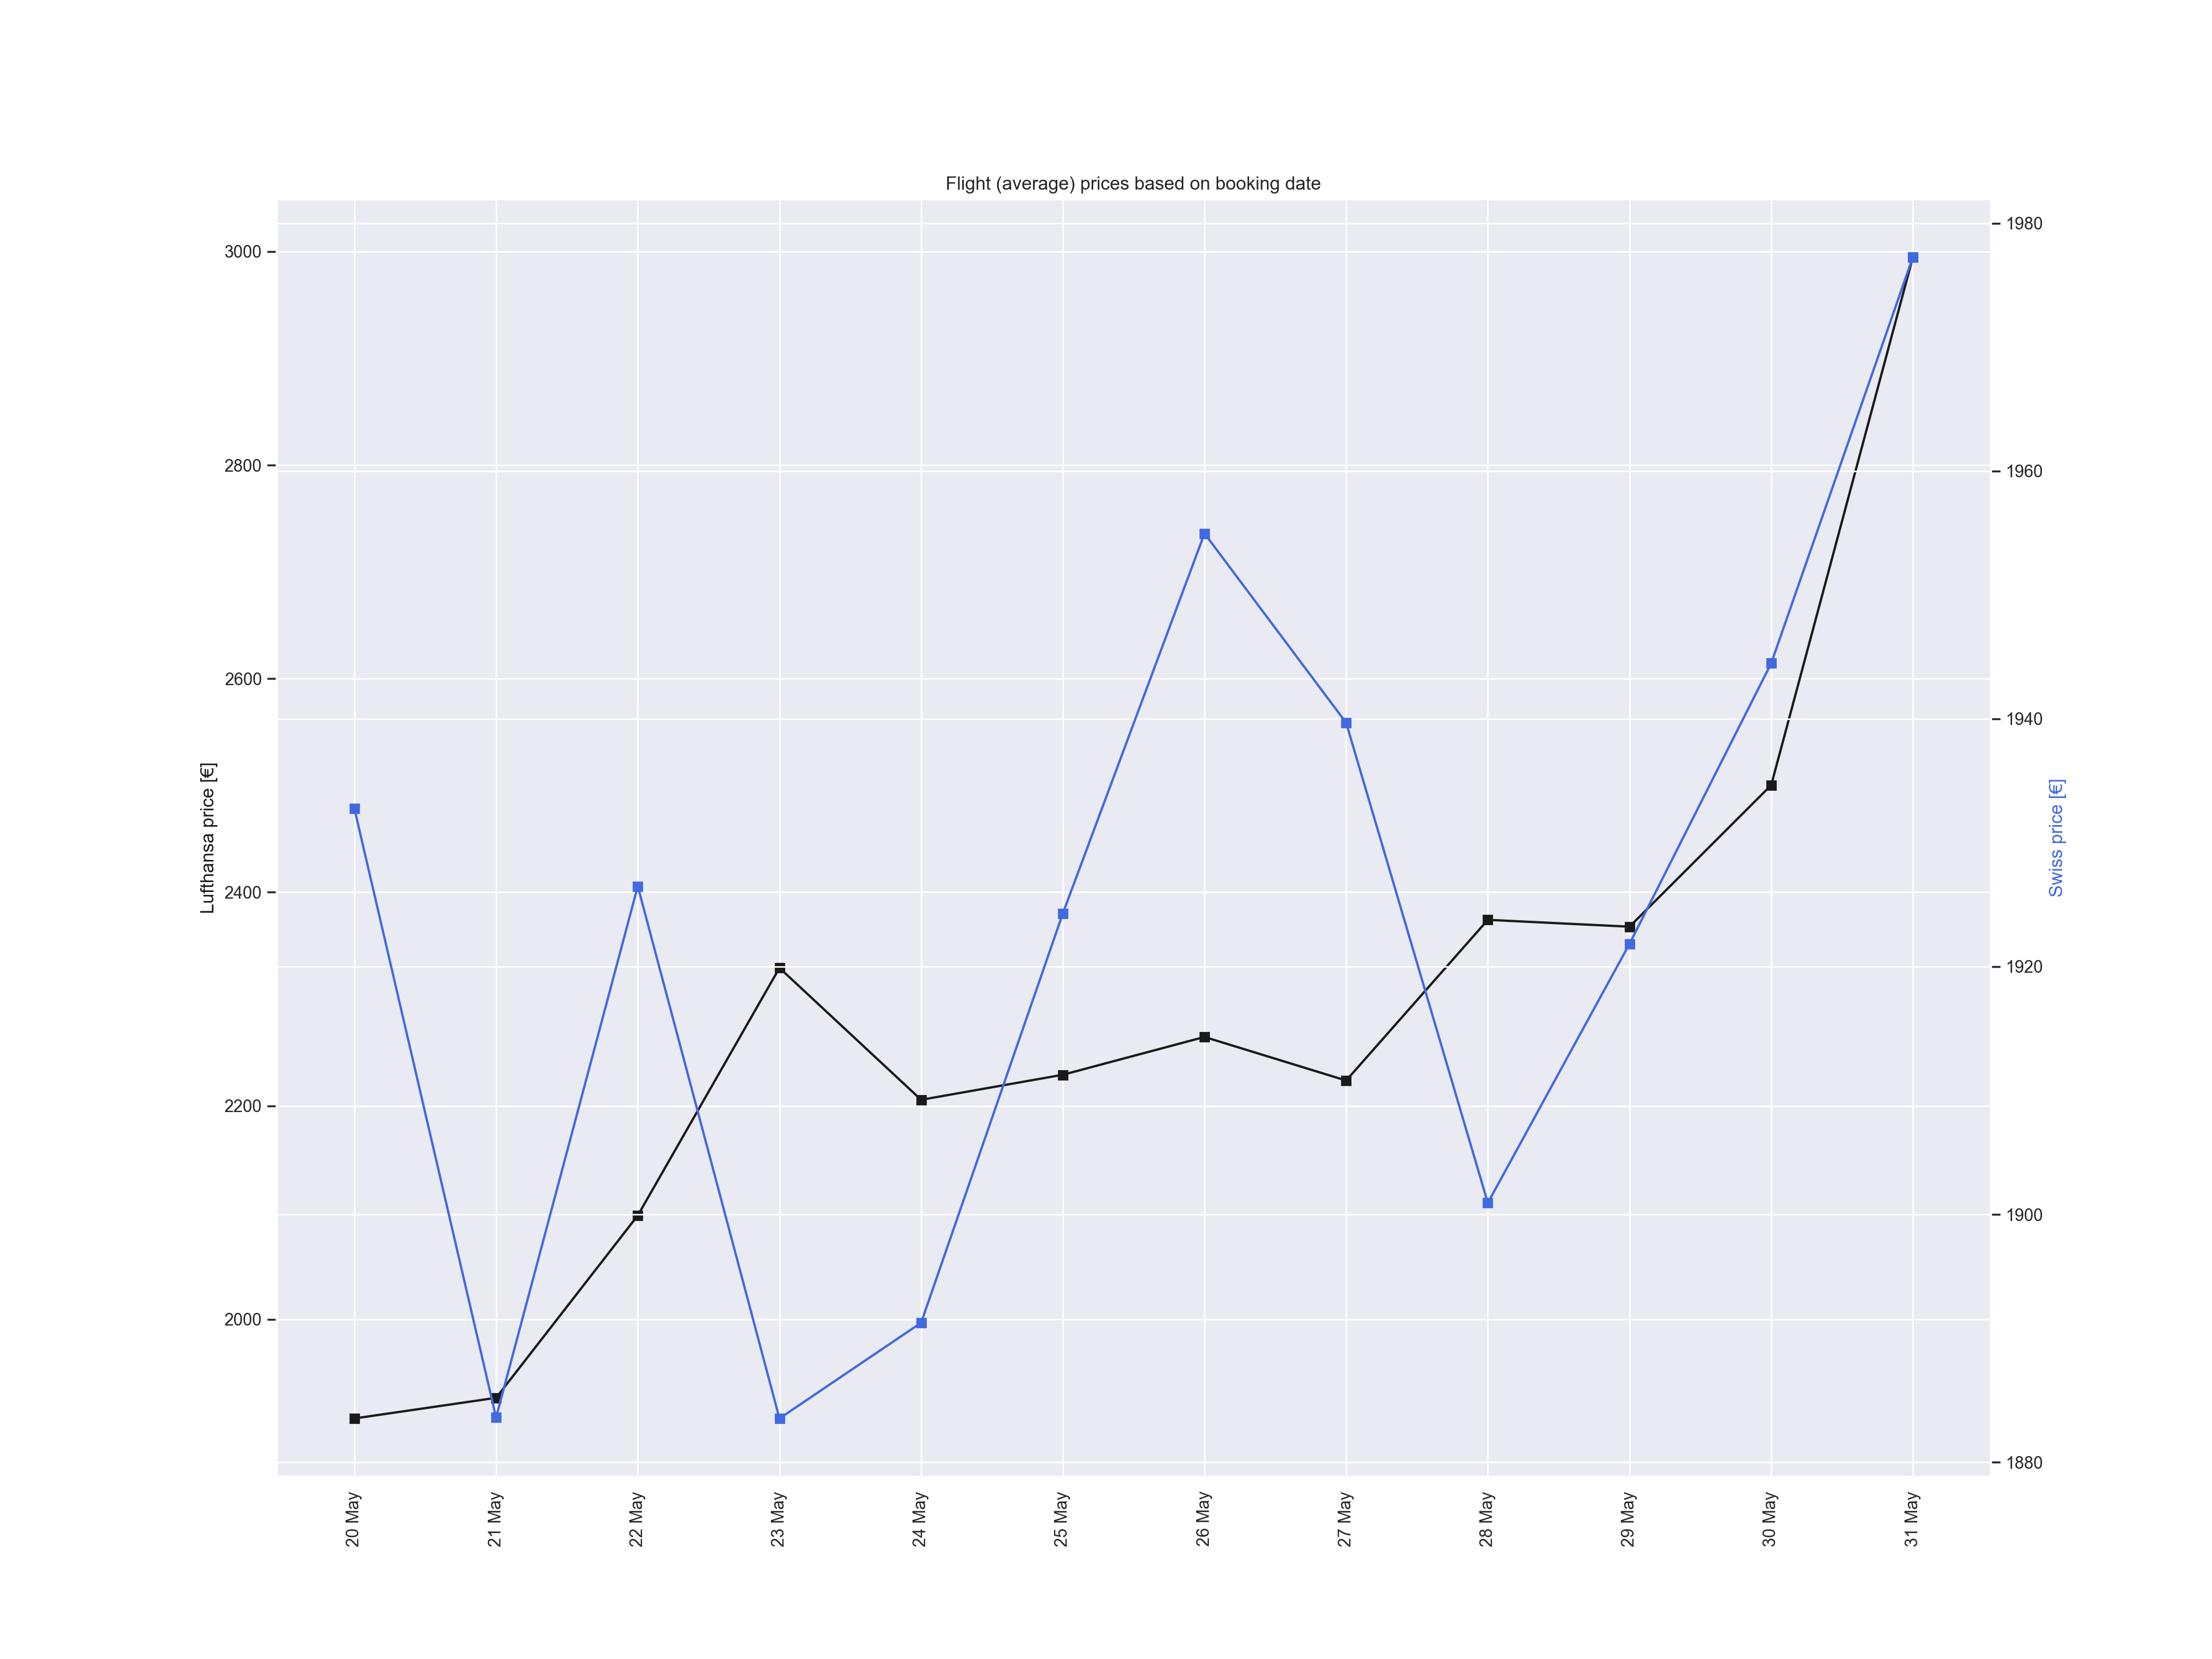

In [50]:
lineplot_day(dataset=sao)

### b. Based on booking time

In [54]:
def lineplot_time(dataset):
    lineplot = dataset.groupby(['out_airline_company','date'])['ticket_price'].agg(['min','mean','max'])
    lineplot = lineplot.reset_index()
    lineplot['date'] = lineplot['date'].dt.strftime('%d %b %I %p')

    date= lineplot[lineplot.out_airline_company == 'Lufthansa']['date'].tolist()
    price_lufthansa = lineplot[lineplot.out_airline_company == 'Lufthansa']['mean'].tolist()
    price_swiss = lineplot[lineplot.out_airline_company == 'Swiss']['mean'].tolist()
    price_swiss = price_swiss[:len(date)]

    # lineplot
    fig, ax1 = plt.subplots(figsize = (20,15))

    ax1.plot(date, price_lufthansa, color = 'k')
    plt.xticks(rotation=90)
    ax1.set_ylabel("Lufthansa price [€]", color = 'k')

    ax2 = ax1.twinx()
    ax2.plot(date, price_swiss, color = "royalblue")
    ax2.set_ylabel("Swiss price [€]", color = "royalblue")

    plt.xticks(rotation=90)
    plt.title('Flight (average) prices based on booking date');

From Brussels to New York City

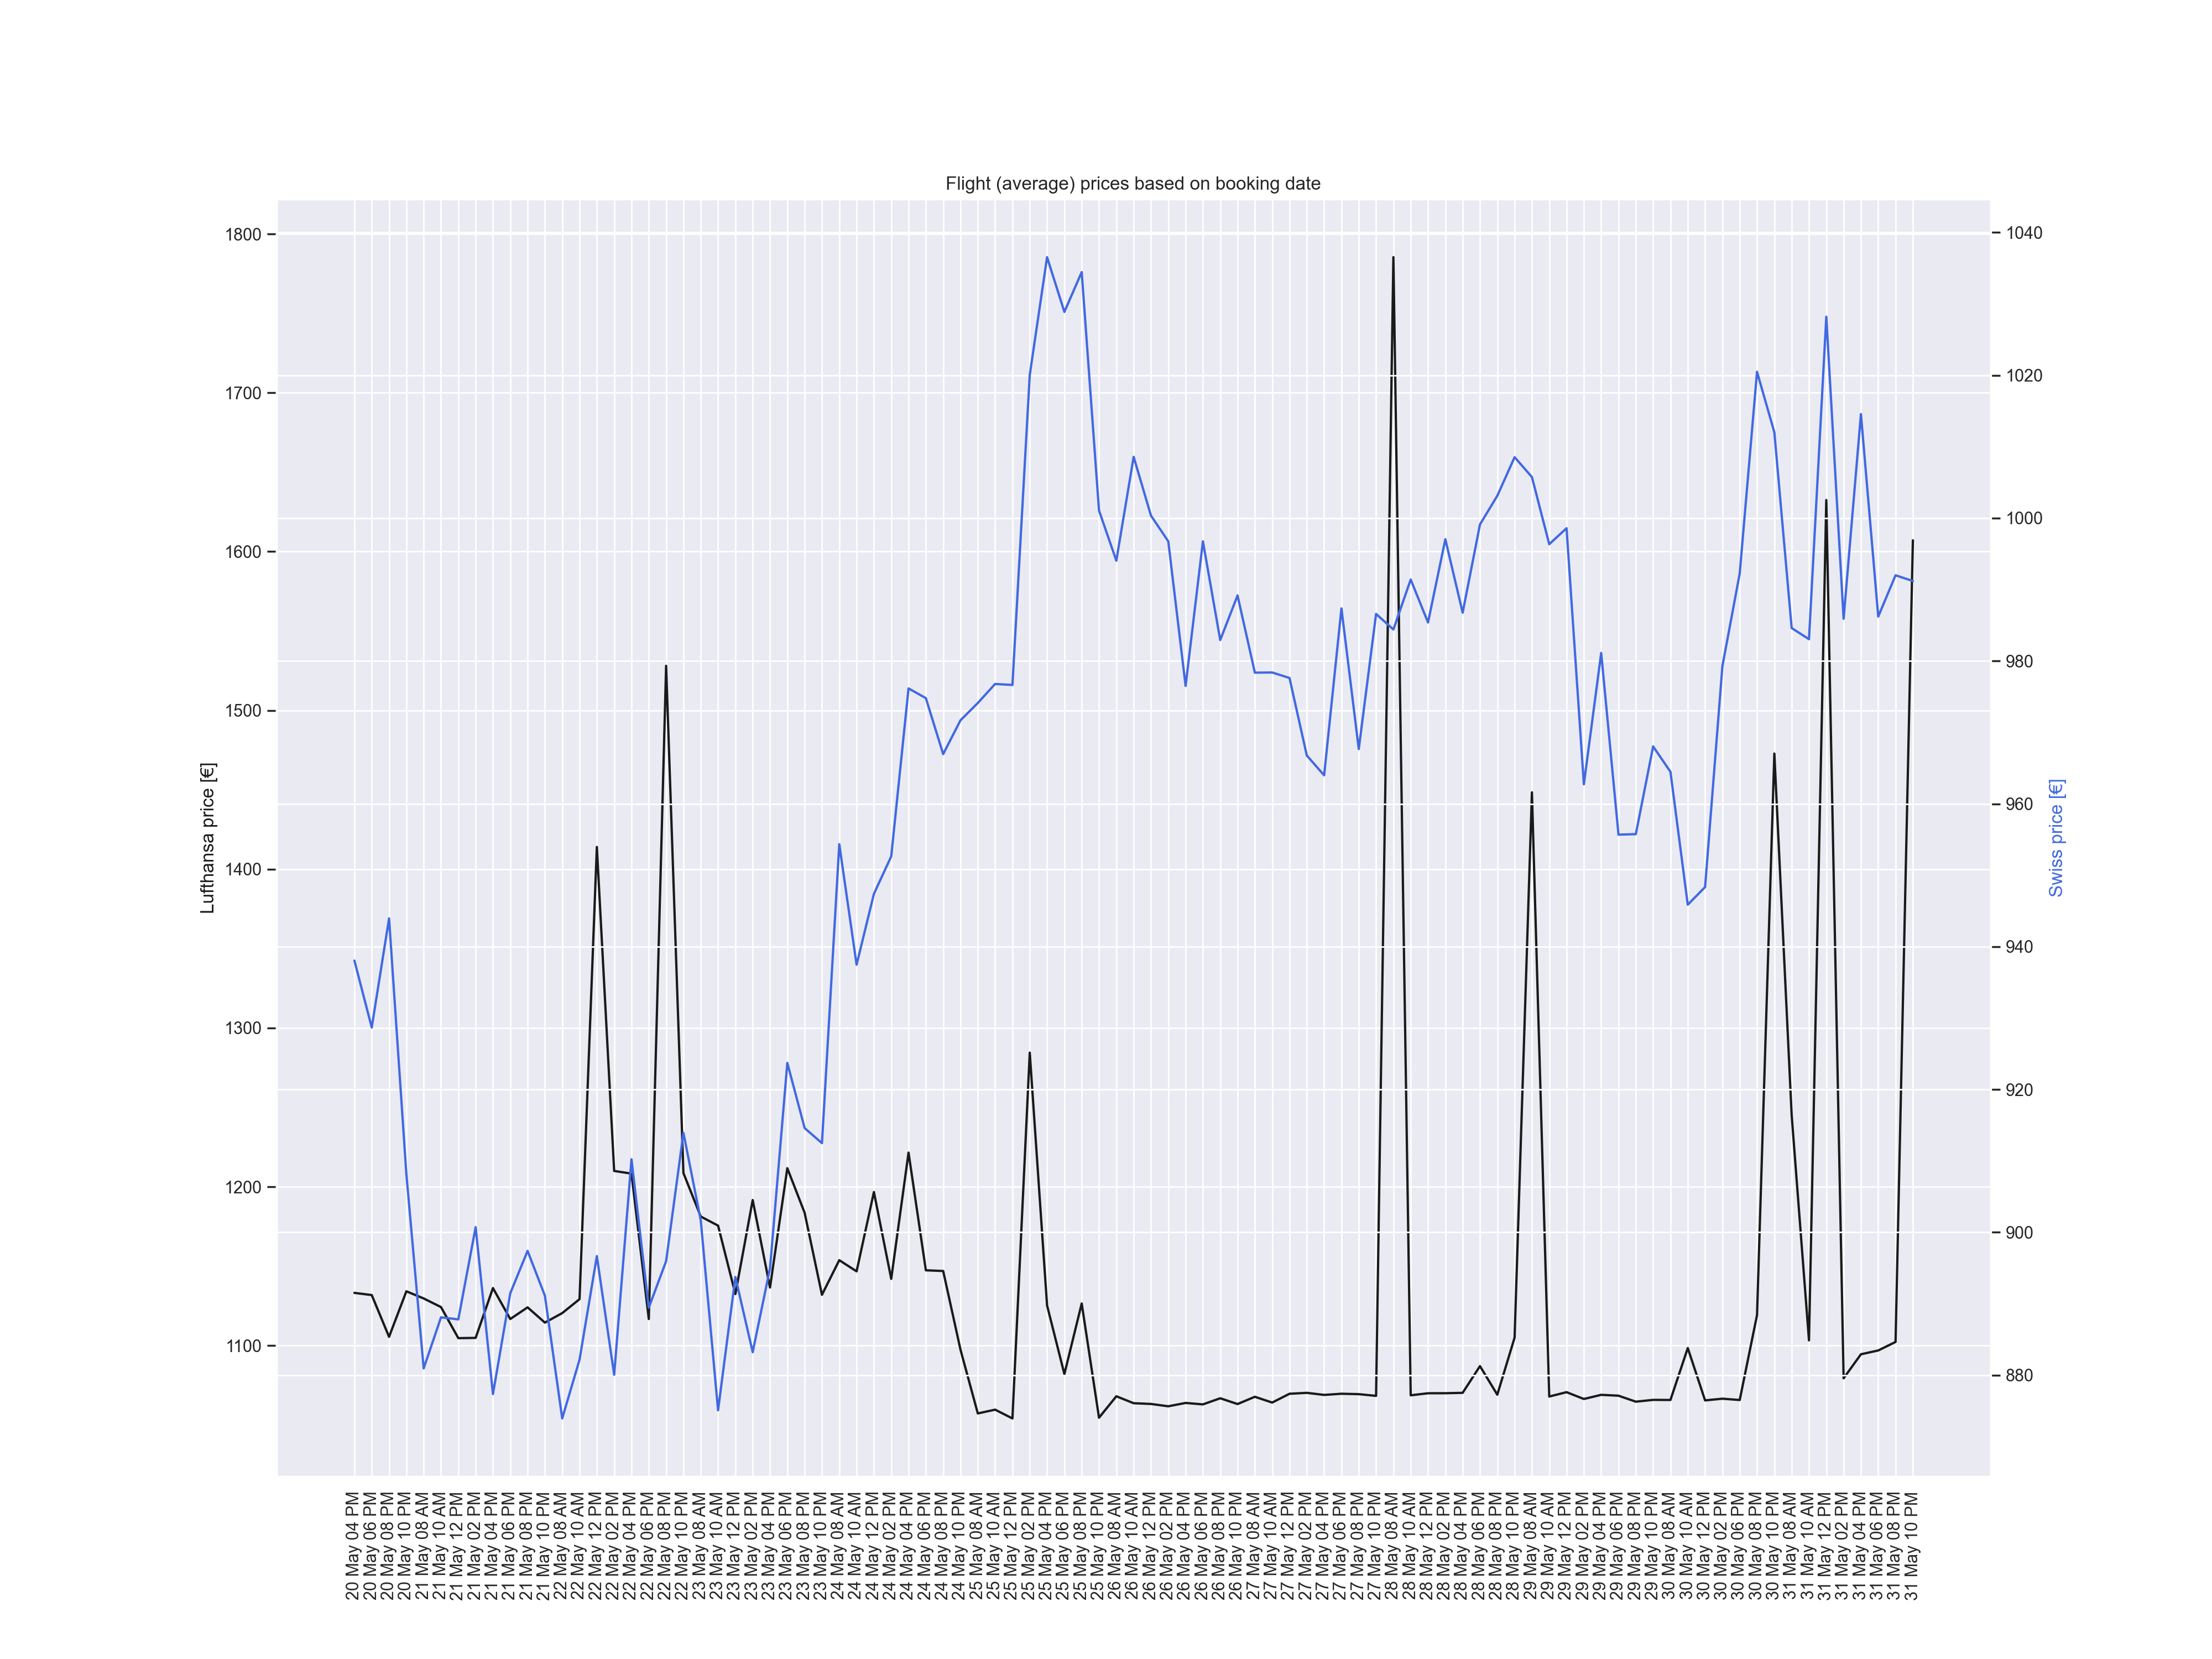

In [55]:
lineplot_time(dataset=nyc)

From Brussels to Sao Paulo

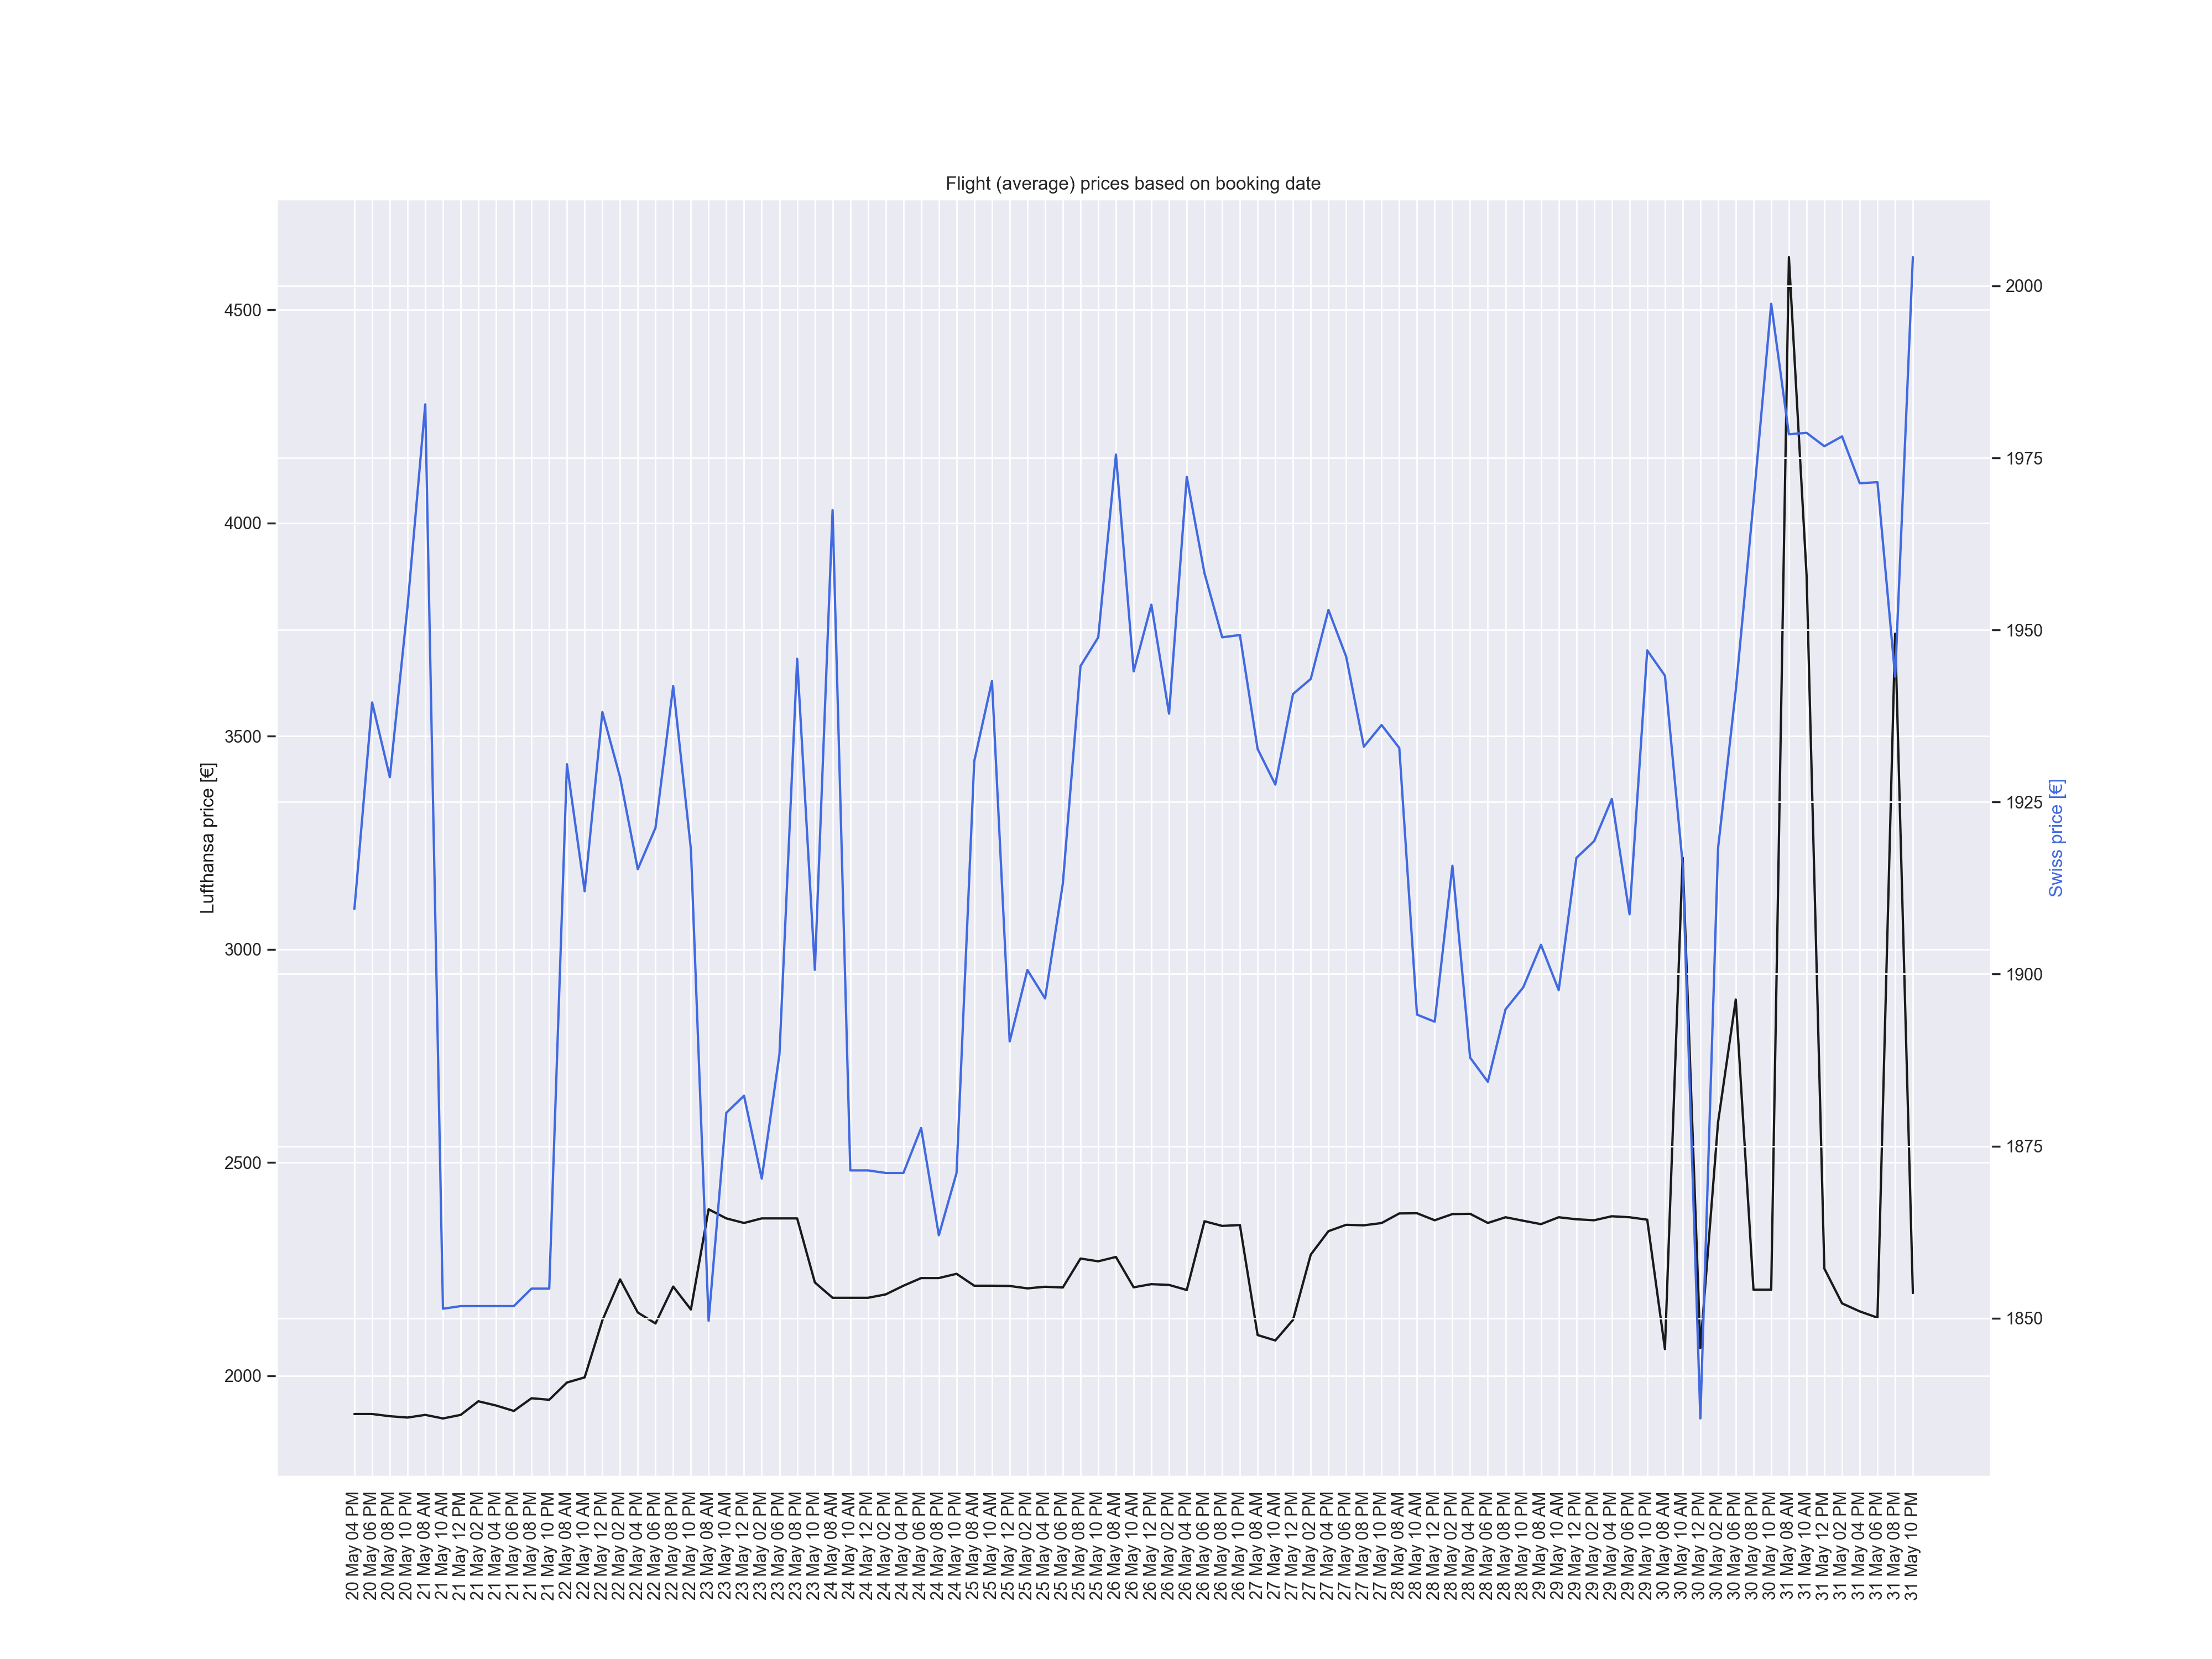

In [56]:
lineplot_time(dataset=sao)

### c. Cost vs duration of flight

In [31]:
def duration_lineplot(dataset):
    plot_data = dataset[["ticket_price", "tot_duration", "out_airline_company"]]
    sns.lineplot(data=plot_data, x='tot_duration', y='ticket_price', hue='out_airline_company', estimator='mean')

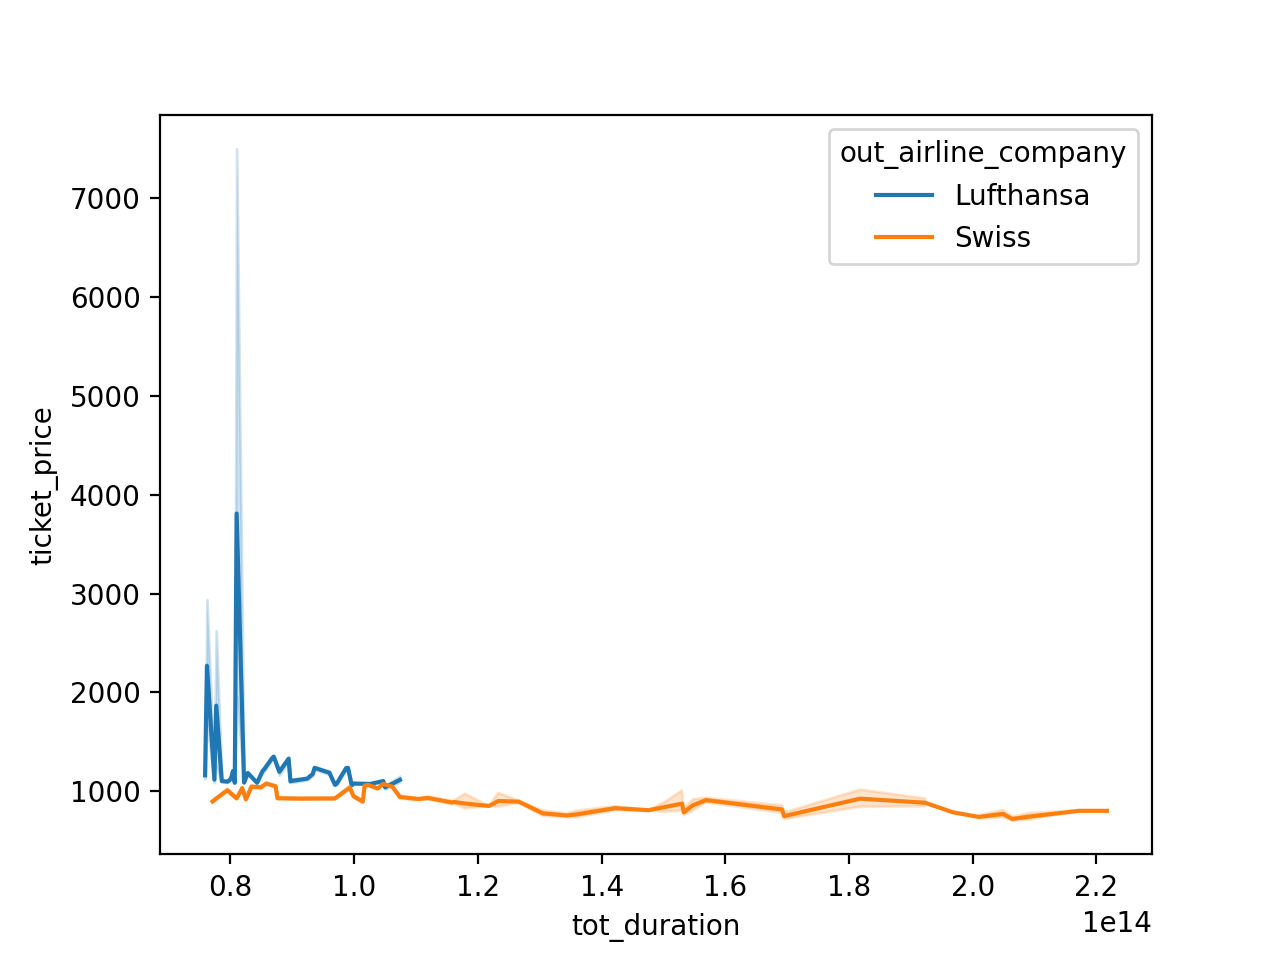

In [32]:
duration_lineplot(dataset=nyc)

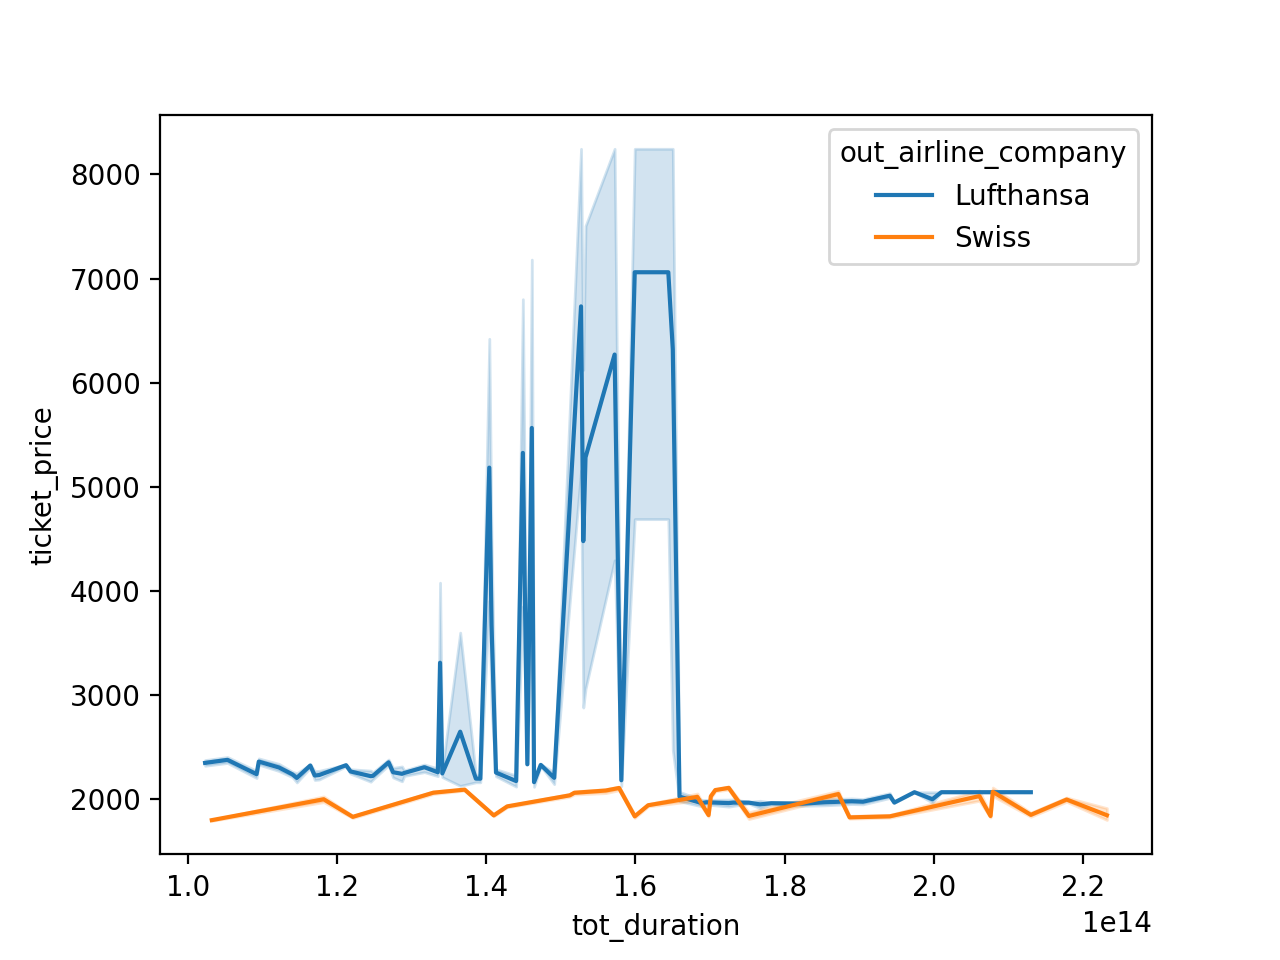

In [33]:
duration_lineplot(dataset=sao)

## Scatter plot <a id="scatter_plot"></a>

### a. Cost vs duration of flight

In [61]:
def scatterplot(dataset):
    scatter_plot = dataset.groupby(['out_airline_company','tot_duration'])['ticket_price'].mean().reset_index(name='price')
    f6= (ggplot(scatter_plot, aes(x='tot_duration', y='price', color='out_airline_company')) + \
    geom_point() + \
    labs(title='Cost vs duration of the flight',
         x='Flight duration',
         y='Flight Price',
         color='Airline') + \
    theme_bw()
    )
    print(f6)

From Brussels to New York City

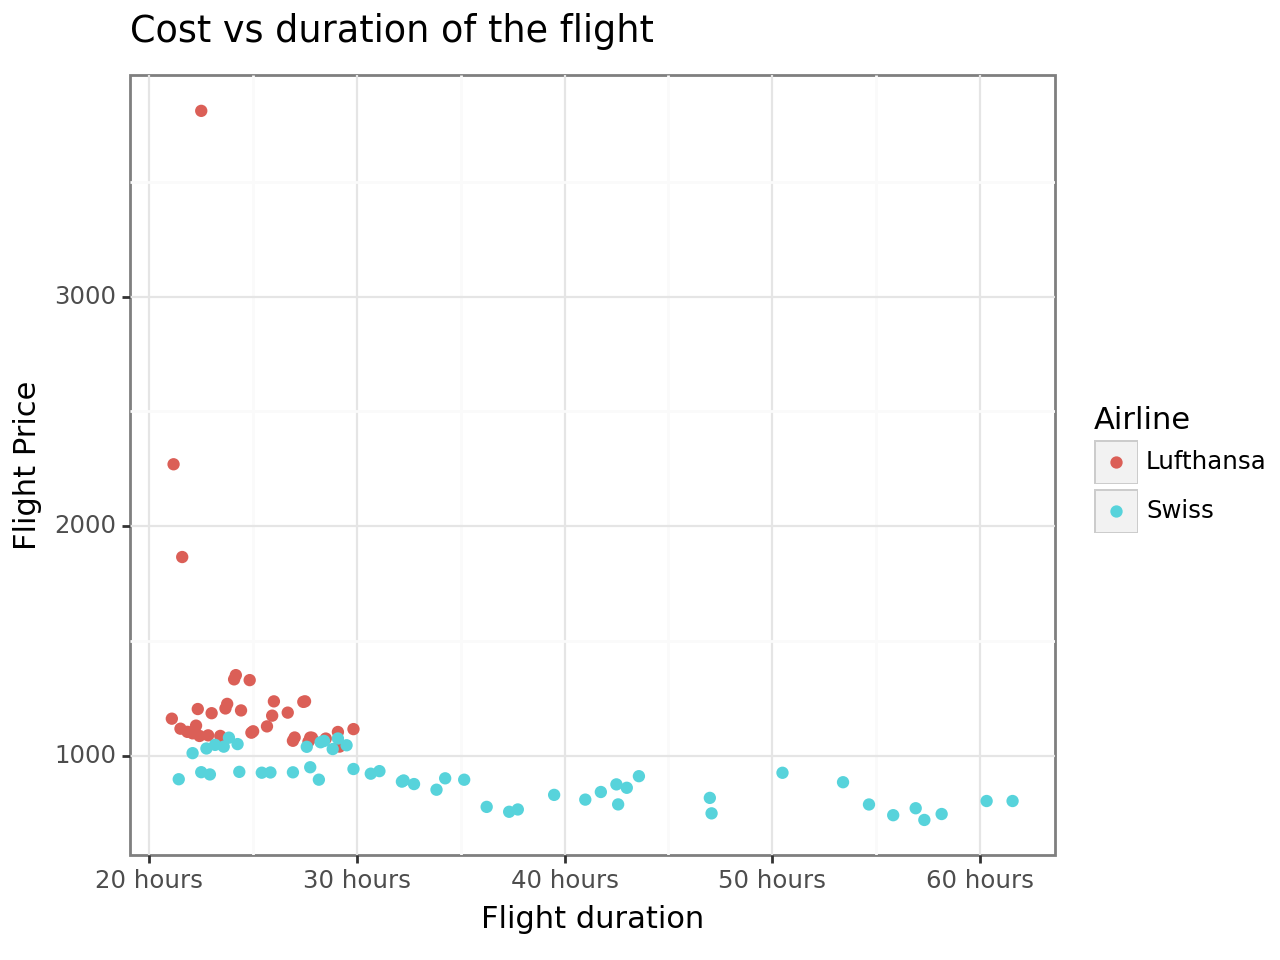

In [63]:
scatterplot(dataset=nyc)

From Brussels to São Paulo

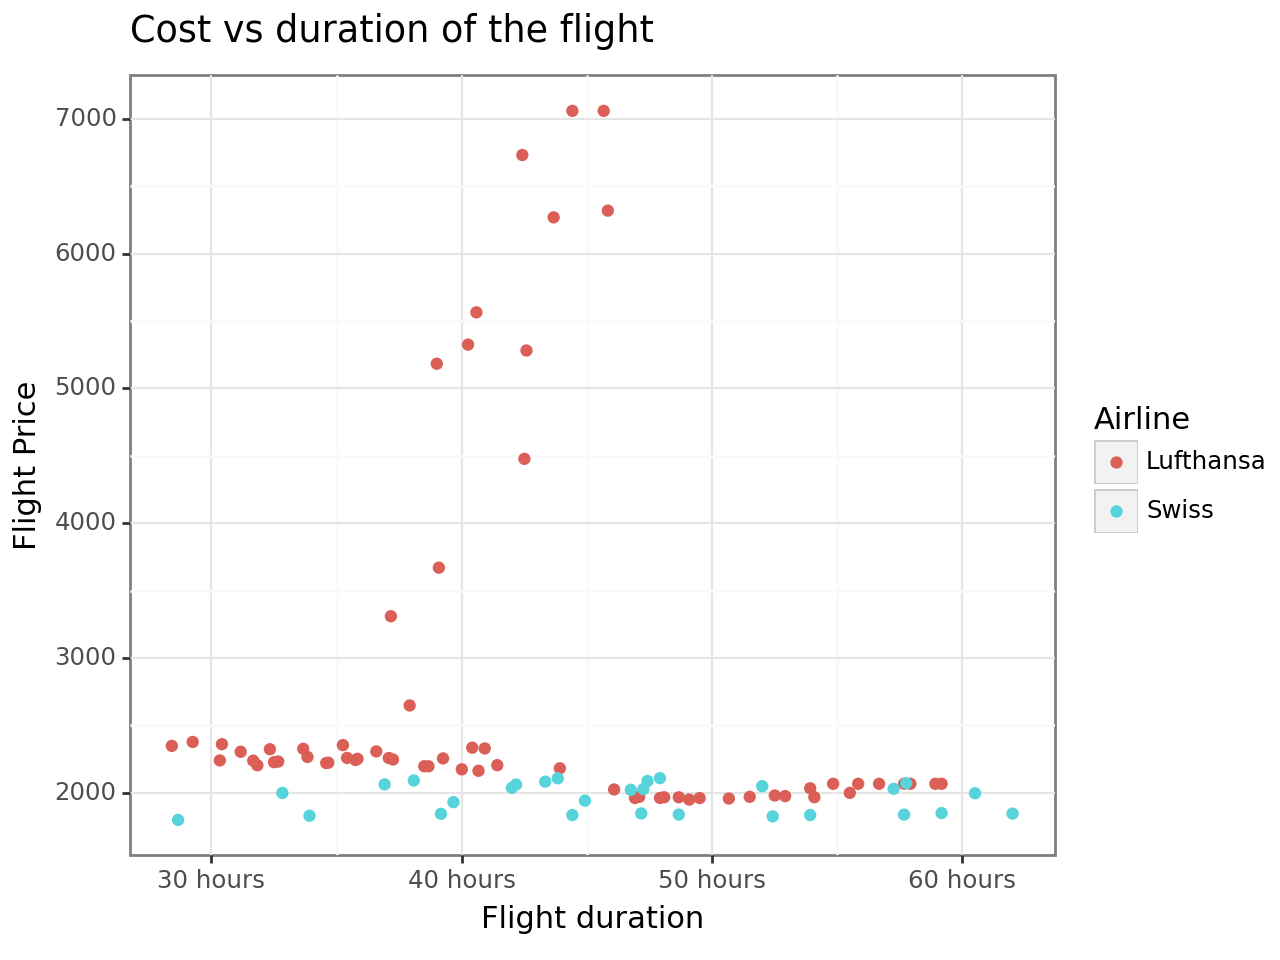

In [64]:
scatterplot(dataset=sao)

## Heatmap <a id="heatmap"></a>

### a. Heatmap correlation

In [38]:
heatmap = dataset[['ticket_price', 'tot_duration','out_dep_time','out_arr_time','in_dep_time','in_arr_time','date','out_stop_num','in_stop_num']]


heatmap['out_dep_time'] = pd.to_datetime(heatmap['out_dep_time'], format='%H:%M')
heatmap['out_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_dep_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')
heatmap['in_arr_time'] = pd.to_datetime(heatmap['out_arr_time'], format='%H:%M')

heatmap

,ticket_price,tot_duration,out_dep_time,out_arr_time,in_dep_time,in_arr_time,date,out_stop_num,in_stop_num
0,1176.01,0 days 21:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
1,923.39,1 days 05:10:00,1900-01-01 13:15:00,1900-01-01 20:05:00,1900-01-01 20:05:00,1900-01-01 20:05:00,2023-05-20 16:00:00,1,1
2,1176.01,0 days 21:50:00,1900-01-01 08:50:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
3,1176.01,0 days 22:05:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
4,1176.01,0 days 22:15:00,1900-01-01 09:35:00,1900-01-01 15:00:00,1900-01-01 15:00:00,1900-01-01 15:00:00,2023-05-20 16:00:00,1,1
...,...,...,...,...,...,...,...,...,...
11614,2126.92,2 days 04:00:00,1900-01-01 15:00:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11615,1976.92,2 days 09:45:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11616,1976.92,2 days 09:45:00,1900-01-01 09:15:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,2,2
11617,2100.92,2 days 09:15:00,1900-01-01 09:45:00,1900-01-01 05:25:00,1900-01-01 05:25:00,1900-01-01 05:25:00,2023-05-31 12:00:00,1,2


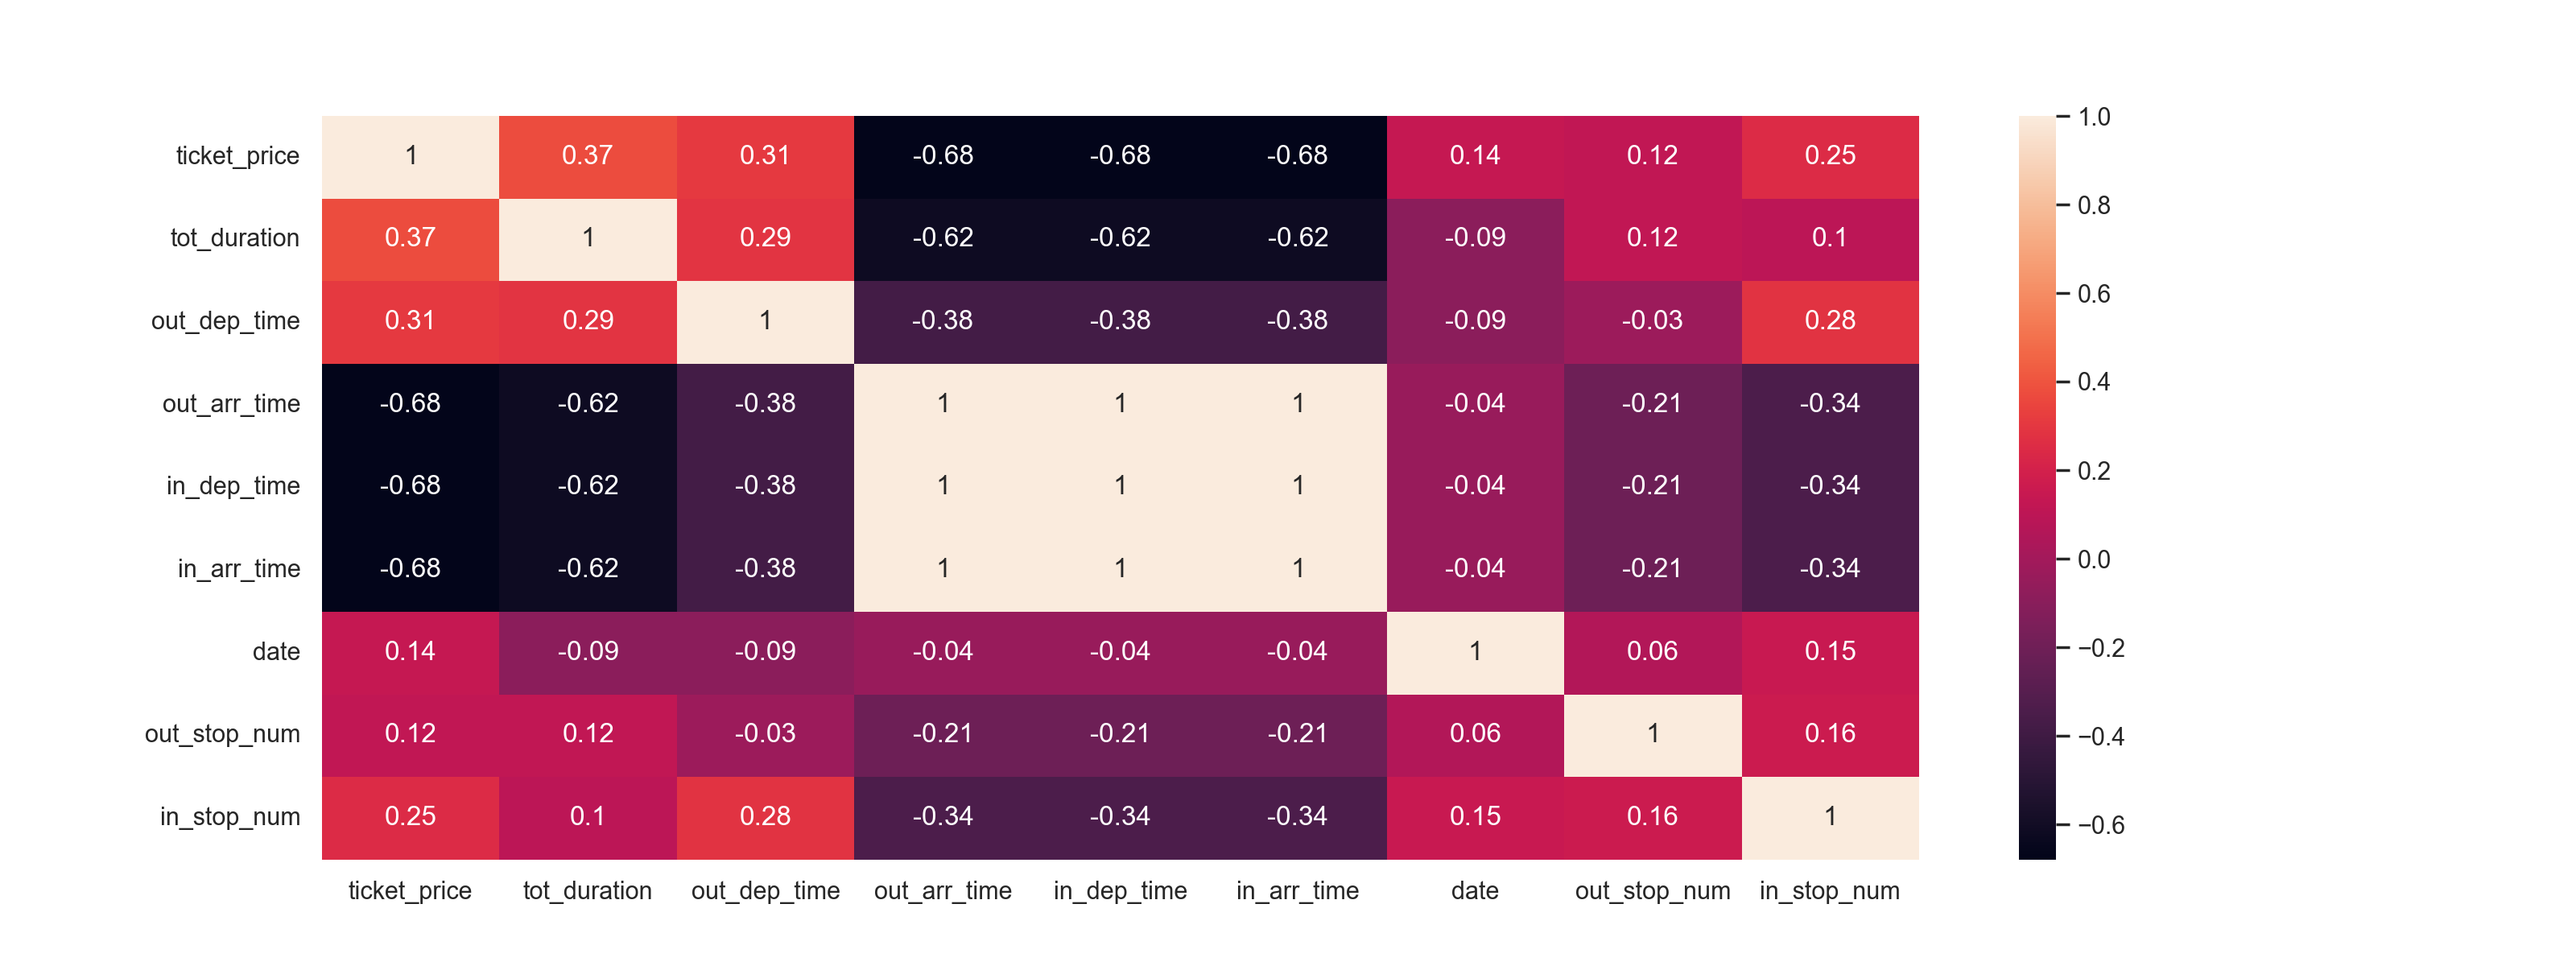

In [39]:
sns.set(rc={'figure.figsize':(16,6)})
correlation_matrix = heatmap.corr().round(2)
sns.heatmap(correlation_matrix, annot=True)
plt.show()